In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.stats import linregress
%matplotlib inline

Load merged datasheet (Vasari, Midline Shift Quantifications, Imaging Features, Clinical Data)

In [14]:
merged_data = pd.read_csv("datasheets/cleaned_merged.csv")

merged_data.head()

# vasari_list = [key for key in merged_data.keys() if "vasari" in key.lower() and any(['text_report', 'region_proportions'])]
vasari_list = [k for k in merged_data if "vasari" in k.lower() and not any(s in k.lower() for s in ["text_report", "region_proportions"])]
midline_shift = ['brats23_metadata_flattened__global__max_midline_shift_mm']
mutation_status = [key for key in merged_data.keys() if any(s in key.lower() for s in ["mgmt_status", "idh_status"])]
brats_masks = ["GBM_Subjects_Spreadsheet__nr_volume", "GBM_Subjects_Spreadsheet__er_volume" , "GBM_Subjects_Spreadsheet__et_volume" , "GBM_Subjects_Spreadsheet__tumor_volume" , "GBM_Subjects_Spreadsheet__tumor_burden" , "GBM_Subjects_Spreadsheet__etiv", "GBM_Subjects_Spreadsheet__resection_status"]
demo_list = ["GBM_Subjects_Spreadsheet__age" , "GBM_Subjects_Spreadsheet__sex", "UCSF-PDGM-Clinical__Final pathologic diagnosis (WHO 2021)"]


# apply the correction (trim spaces first, preserve NaNs)
s = merged_data[col]
merged_data[col] = s.where(s.isna(), s.astype(str).str.strip())

merged_data["GBM_Subjects_Spreadsheet__sex"] = [bool(x) for x in merged_data["GBM_Subjects_Spreadsheet__sex"]-1]
merged_data["GBM_Subjects_Spreadsheet__sex"] = [
    "Male" if bool(x) else "Female" for x in (merged_data["GBM_Subjects_Spreadsheet__sex"] - 1)
]


merged_data['GBM_Subjects_Spreadsheet__mgmt_status'] = [
    "Methylated" if bool(x) else "Unmethylated" for x in (merged_data["GBM_Subjects_Spreadsheet__mgmt_status"])
]

merged_data['GBM_Subjects_Spreadsheet__idh_status'] = [
    "Mutant" if bool(x) else "Wildtype" for x in (merged_data["GBM_Subjects_Spreadsheet__idh_status"])
]

merged_data['GBM_Subjects_Spreadsheet__resection_status'] = [
    "Gross Total Resection (>90%)" if bool(x) else "Biopsy/Subtotal Resection (<90%)" for x in (merged_data["GBM_Subjects_Spreadsheet__resection_status"])
]

merged_data['brats23_metadata_flattened__global__max_midline_shift_mm'] = [abs(x) for x in merged_data['brats23_metadata_flattened__global__max_midline_shift_mm']]

In [12]:
# PLOTTING FUNCTION
import matplotlib.pyplot as plt
from scipy.stats import linregress, mannwhitneyu, kruskal
import pandas as pd
import numpy as np
import math

# Muted modern palette
_PALETTE = ["#7B9ACC", "#9ACCA6", "#E4A972", "#D98BA3", "#C2A5CF", "#85C1DC"]

def _p_to_stars(p):
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 0.05: return "*"
    return "n.s."

def _add_sig_bar(ax, x1, x2, y, h, text):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], color="#333", linewidth=1.6)
    ax.text((x1 + x2) / 2, y + h*1.05, text, ha="center", va="bottom",
            fontsize=10, fontweight="bold")

def plots(df, x_list, y_variable="GBM_Subjects_Spreadsheet__survival_days"):
    ncols = 3
    nrows = math.ceil(len(x_list) / ncols)

    plt.rcParams.update({
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "savefig.facecolor": "white"
    })

    plt.figure(figsize=(8 * ncols, 5 * nrows))
    y_all = pd.to_numeric(df[y_variable], errors="coerce")

    for idx, x_variable in enumerate(x_list, start=1):
        ax = plt.subplot(nrows, ncols, idx)
        x_raw = df[x_variable]

        # Detect boolean explicitly; treat as non-numeric
        is_bool = pd.api.types.is_bool_dtype(x_raw)
        is_numeric = pd.api.types.is_numeric_dtype(x_raw)

        # Handle numeric strings (e.g., "123") as numeric
        if not (is_numeric or is_bool):
            x_num_try = pd.to_numeric(x_raw, errors="coerce")
            is_numeric = x_num_try.notna().mean() > 0.8
        else:
            x_num_try = x_raw

        #  Numeric branch 
        if is_numeric and not is_bool:
            x = pd.to_numeric(x_raw, errors="coerce")
            y = y_all
            valid = x.notna() & y.notna()
            ax.scatter(x[valid], y[valid], alpha=0.75, s=26, color="#5B8FF9", edgecolor="none")

            if valid.sum() > 2:
                slope, intercept, r, p, _ = linregress(x[valid], y[valid])
                xx = np.linspace(x[valid].min(), x[valid].max(), 100)
                ax.plot(xx, slope * xx + intercept, color="#1F2937", linewidth=2.2)
                stats_text = f"y = {slope:.2f}x + {intercept:.2f}\nR = {r:.2f}\np = {p:.2e}"
                ax.text(1.02, 0.5, stats_text, transform=ax.transAxes,
                        fontsize=10, va="center", ha="left",
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#999", alpha=0.95))

        #  Categorical / Boolean branch 
        else:
            tmp = pd.DataFrame({x_variable: x_raw, y_variable: y_all}).dropna()
            if tmp.empty:
                ax.set_xlabel(x_variable); ax.set_ylabel(y_variable)
                continue

            cats = pd.Index(sorted(tmp[x_variable].unique()))
            groups = [tmp.loc[tmp[x_variable] == c, y_variable].values for c in cats]

            # colorful boxplot
            bp = ax.boxplot(
                groups,
                tick_labels=[str(c) for c in cats],
                patch_artist=True,
                medianprops=dict(color="#333", linewidth=2),
                boxprops=dict(linewidth=1.2, color="#555"),
                whiskerprops=dict(linewidth=1.2, color="#777"),
                capprops=dict(linewidth=1.2, color="#777"),
                flierprops=dict(marker="o", markersize=3,
                                markerfacecolor="#666", markeredgecolor="none", alpha=0.4),
            )
            for i, patch in enumerate(bp["boxes"]):
                patch.set_facecolor(_PALETTE[i % len(_PALETTE)])
                patch.set_alpha(0.6)
                patch.set_edgecolor("#666")

            # overlay jittered points
            x_positions = np.arange(1, len(groups) + 1)
            for xi, g in zip(x_positions, groups):
                if len(g) == 0: 
                    continue
                xj = xi + np.random.uniform(-0.08, 0.08, size=len(g))
                ax.scatter(xj, g, s=10, color="#111", alpha=0.35, linewidths=0)

            ax.tick_params(axis="x", rotation=15)

            # significance
            if len(groups) == 2:
                g1, g2 = groups
                if len(g1) > 0 and len(g2) > 0:
                    stat, p = mannwhitneyu(g1, g2, alternative="two-sided")
                    stars = _p_to_stars(p)
                    y_max = max(np.max(g1), np.max(g2))
                    y_min = min(np.min(g1), np.min(g2))
                    h = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
                    _add_sig_bar(ax, 1, 2, y_max + h, h, stars + f" (p={p:.2e})")
            elif len(groups) > 2:
                if all(len(g) > 0 for g in groups):
                    stat, p = kruskal(*groups)
                    # ax.text(0.5, 1.02, f"Kruskal–Wallis p={p:.2e} ({_p_to_stars(p)})",
                    #         transform=ax.transAxes, ha="center", va="bottom",
                    #         fontsize=10, fontweight="bold")

        ax.set_xlabel(x_variable)
        ax.set_ylabel(y_variable)
        ax.set_title(f"{x_variable.split('brats23_metadata_flattened__global__')[-1]} vs {y_variable}")

        # clean white + grid
        ax.set_facecolor("white")
        ax.grid(True, axis="y", color="#E6E6E6", linewidth=0.6)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.tight_layout(h_pad=3.0)
    plt.show()



VASARI Features

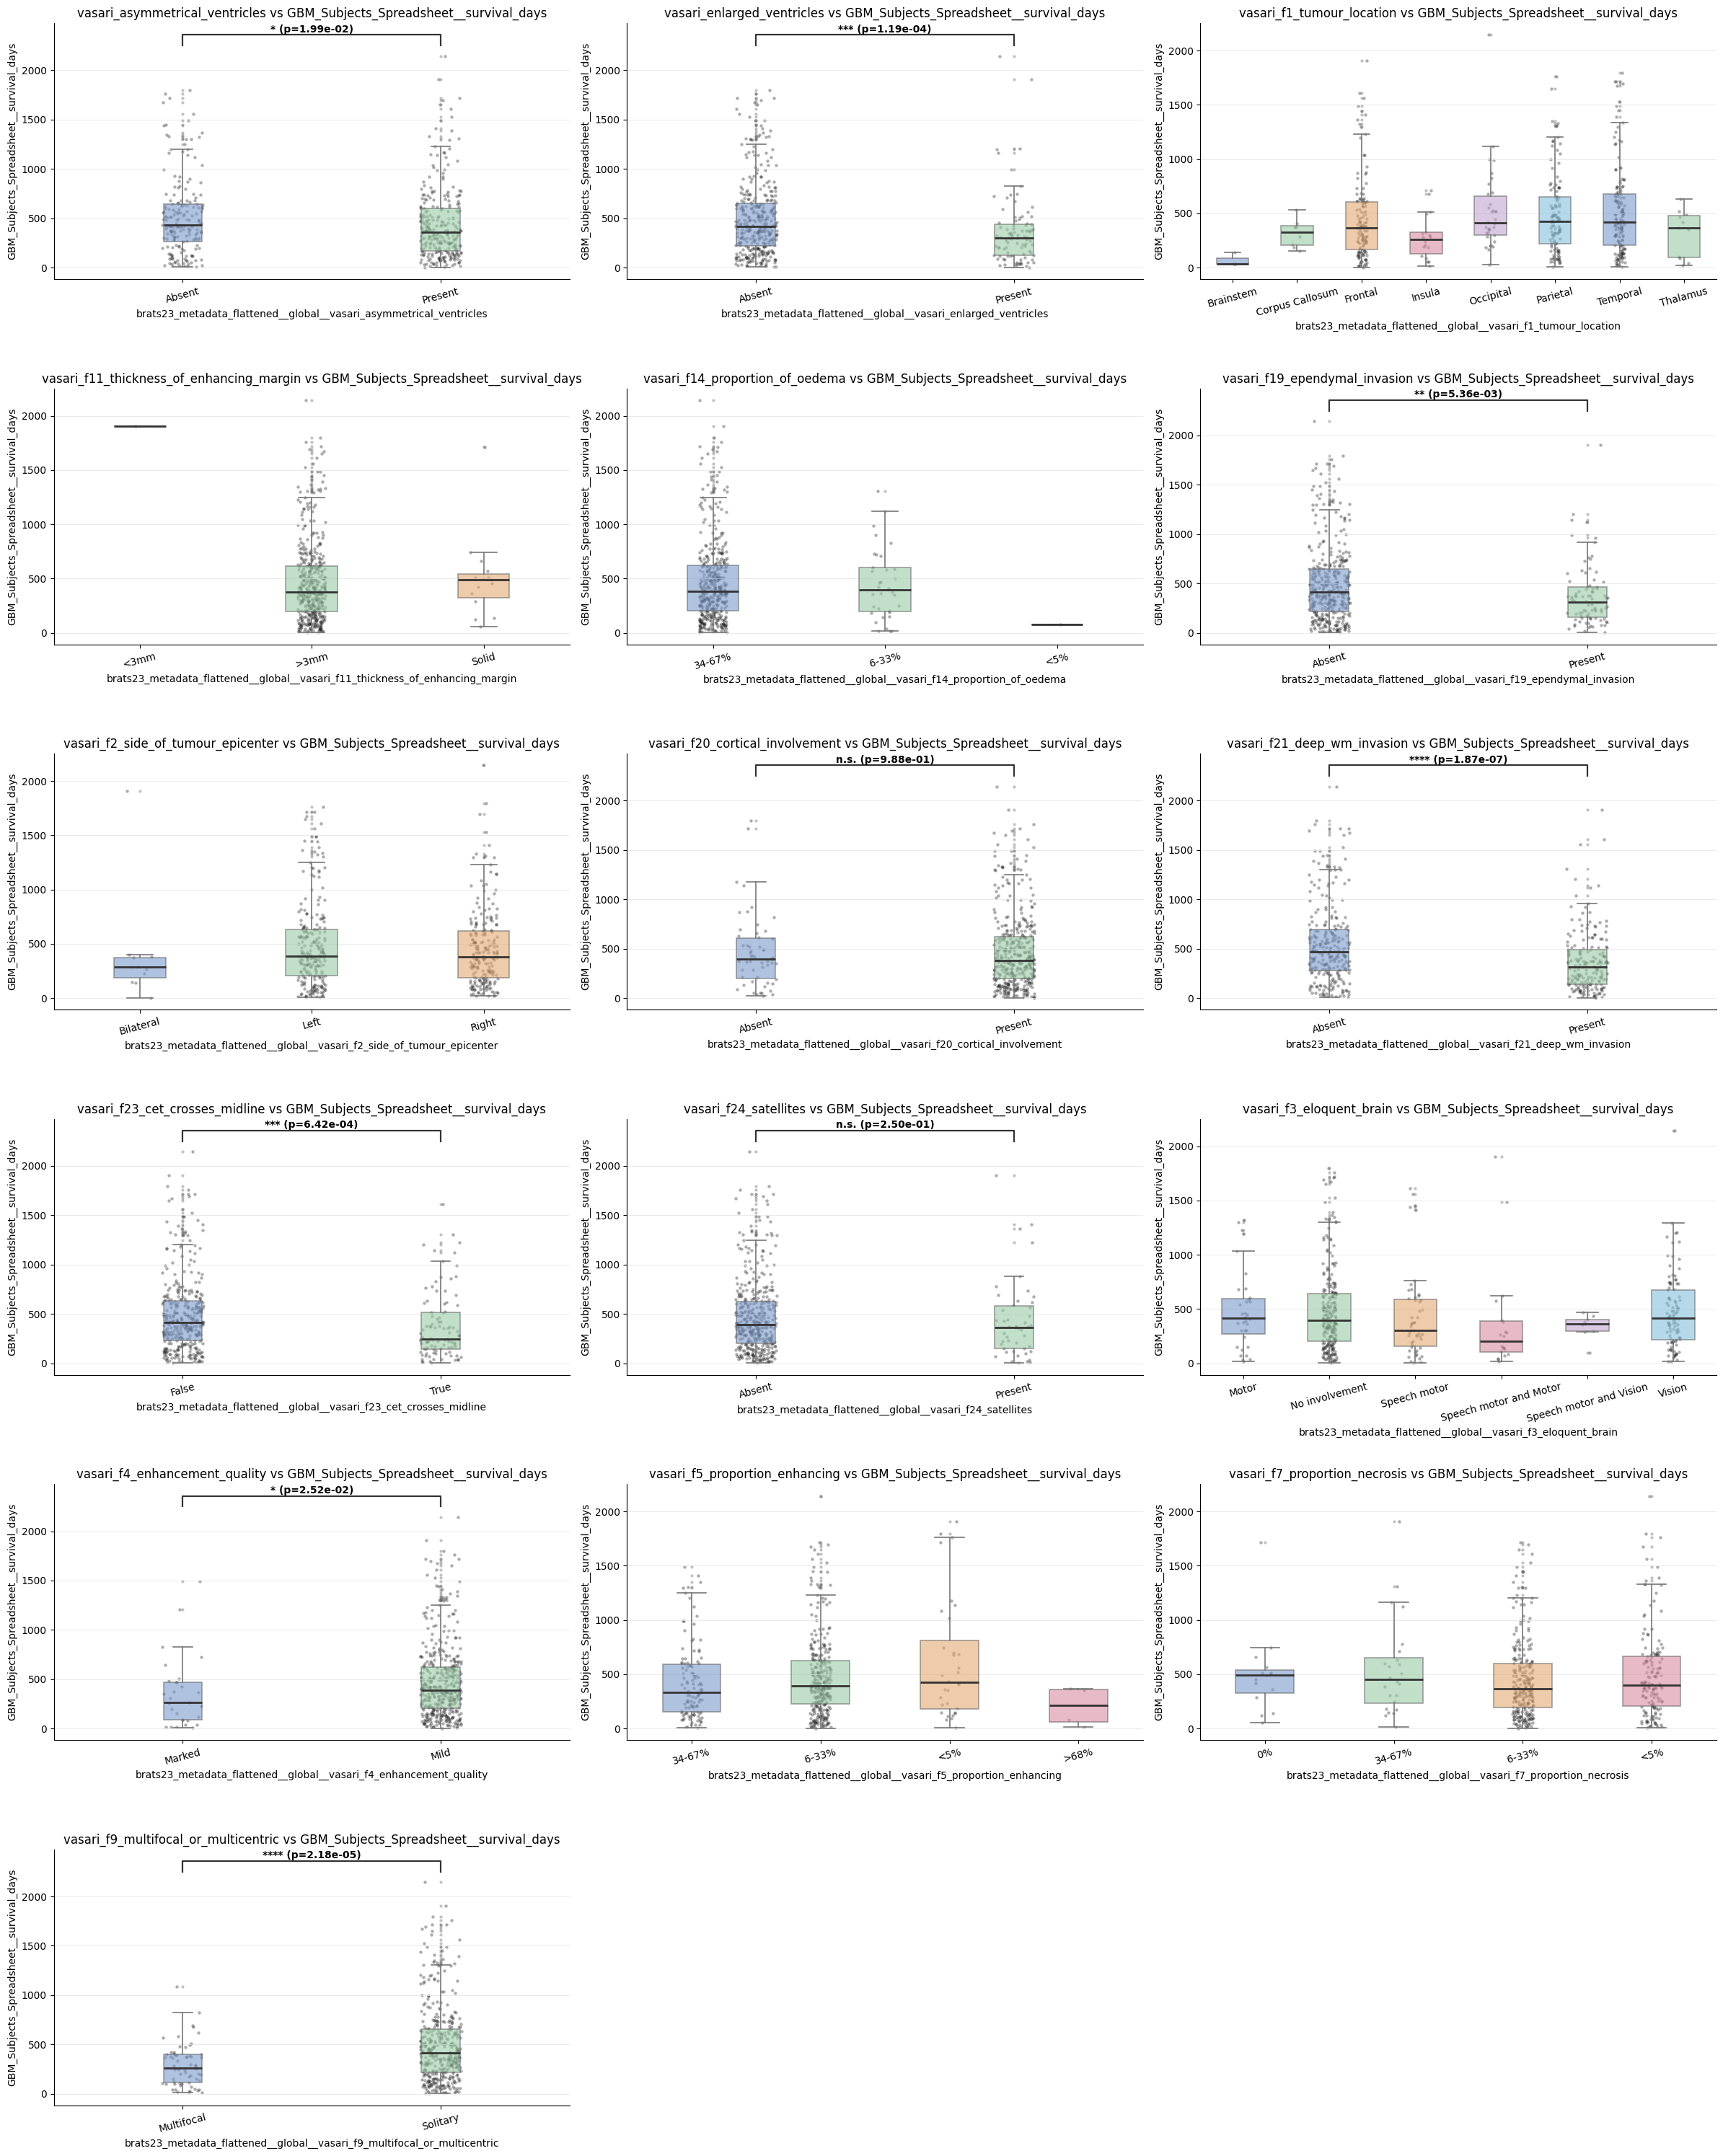

In [15]:
plots(df=merged_data,x_list=vasari_list)


BraTS Segmentation Features

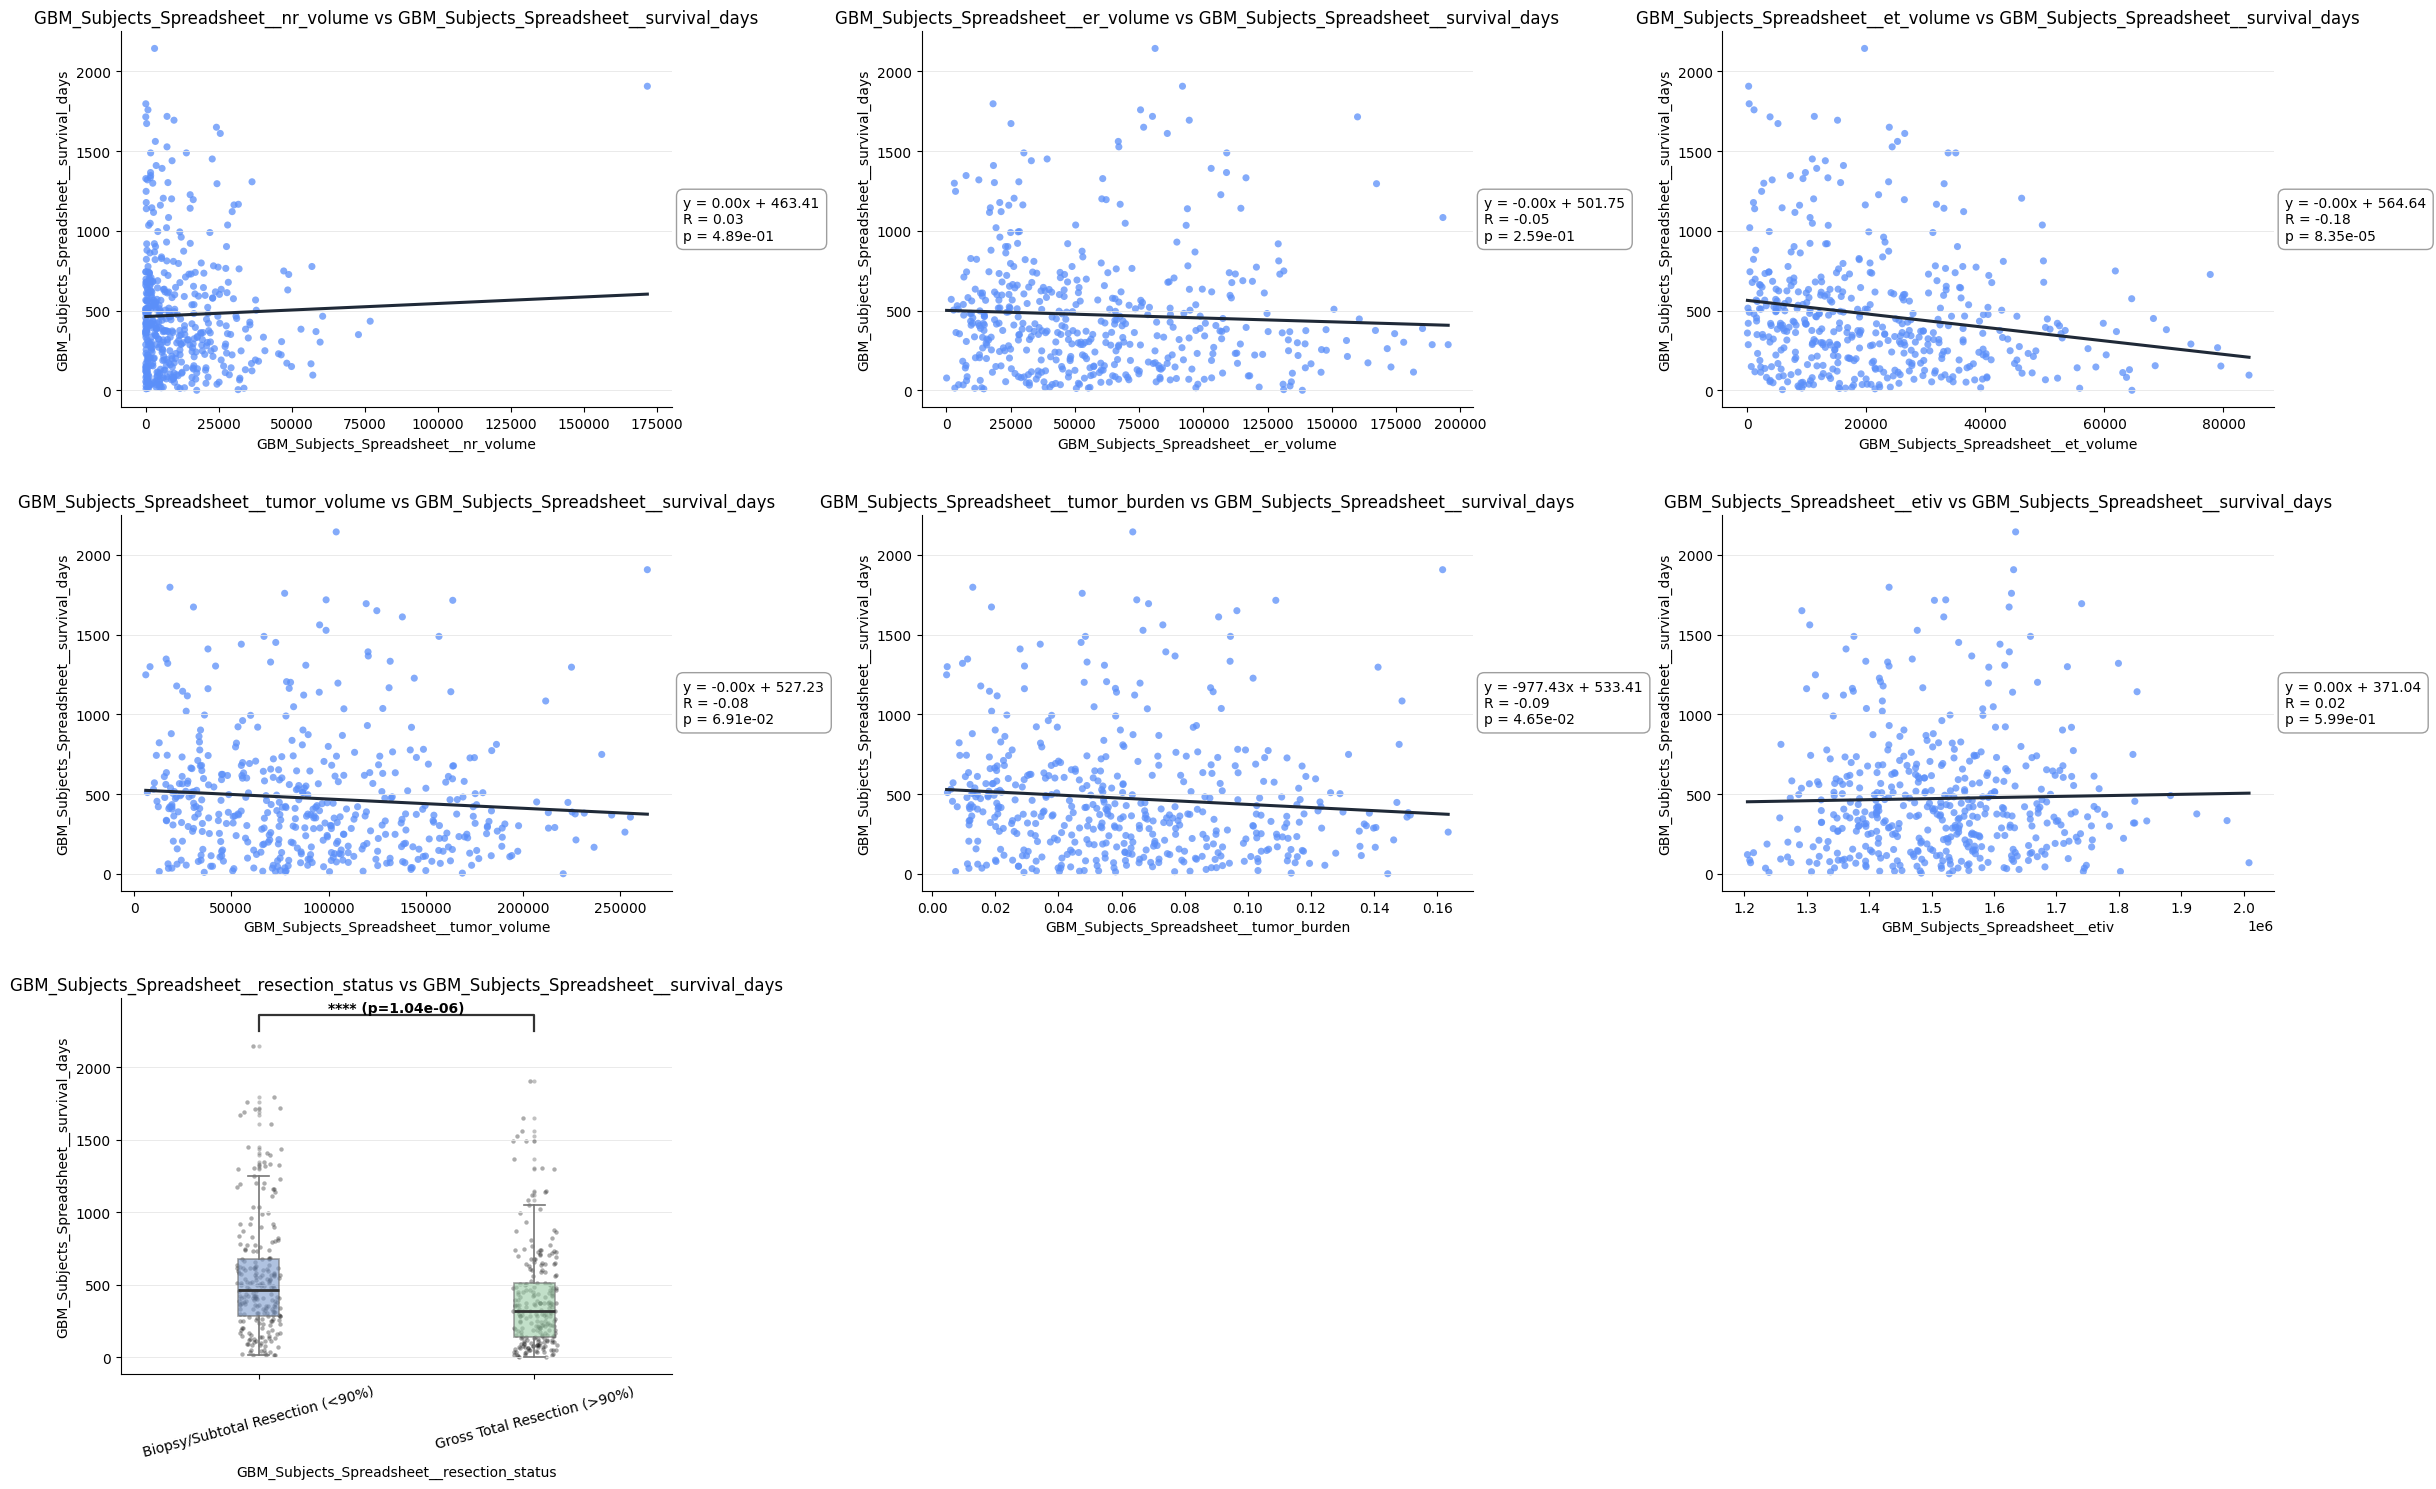

In [6]:
plots(df=merged_data,x_list=brats_masks)s

Patient Demographics

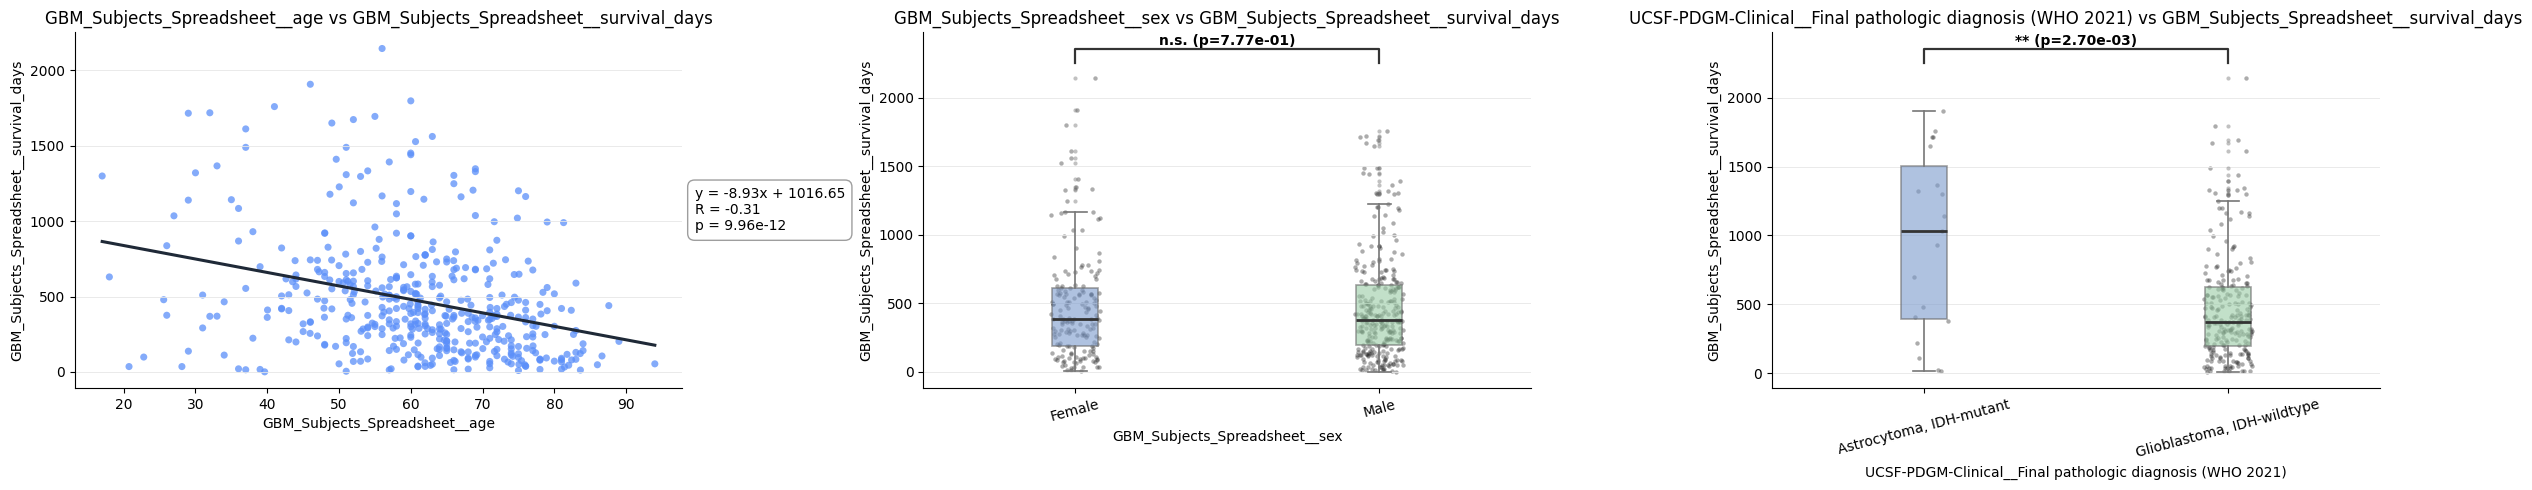

In [7]:
plots(df=merged_data,x_list=demo_list)


Mutation Status

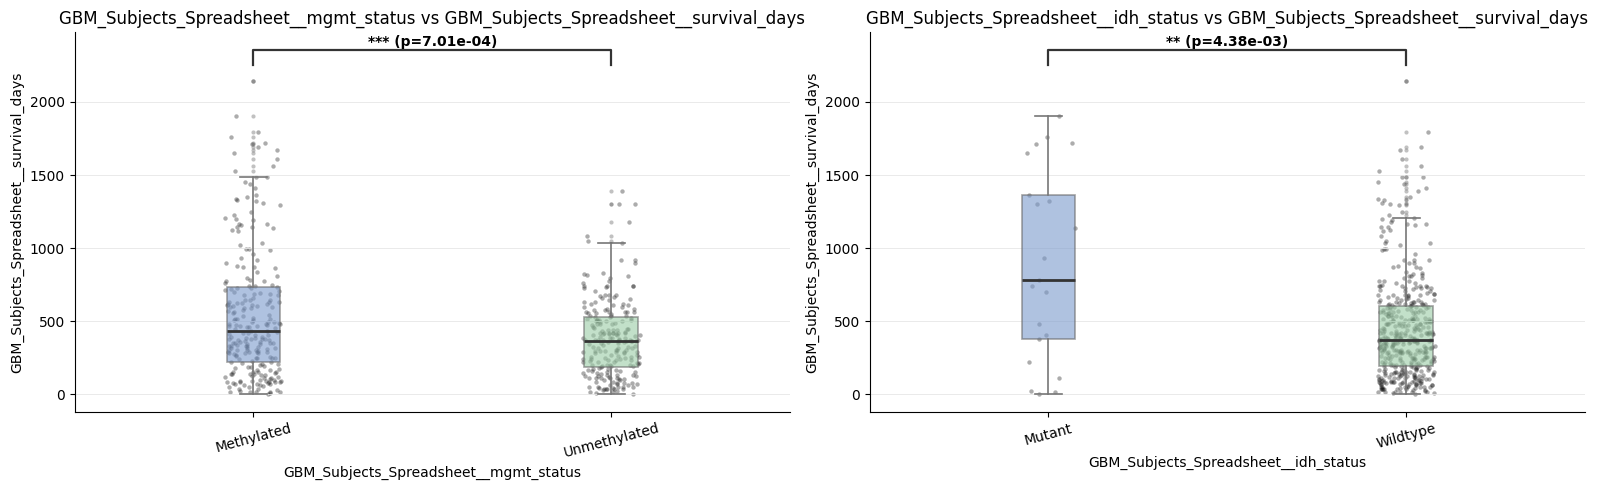

In [8]:
plots(df=merged_data,x_list=mutation_status)

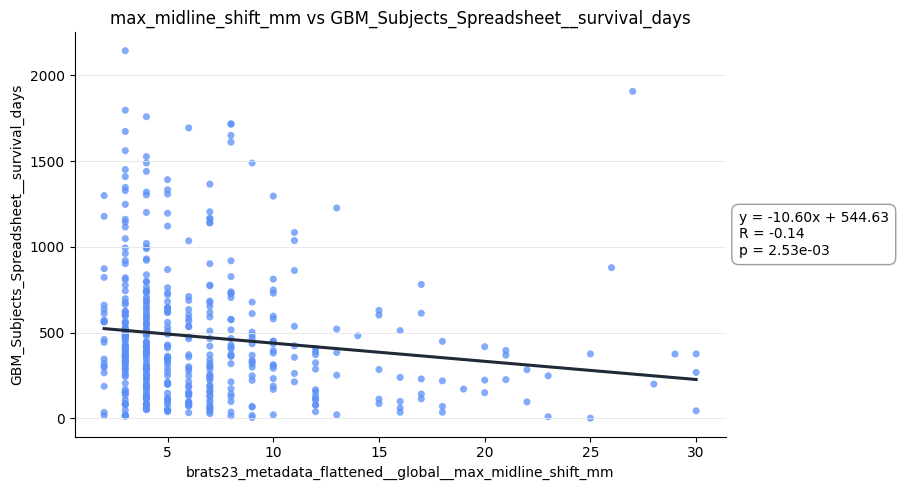

In [9]:
plots(df=merged_data,x_list=midline_shift)